# Classification of movie reviews with SimpleRNN and LSTM

In previous notebooks (`1_classify_movie_reviews` and `9_embeddings_movie_reviews`) we classified movie reviews using standard feed-forward neural networks. So far three approaches have been compared, and their performance on the validation set summarizes as follows:
    - Standard feed-forward NN with one-hot encoding of words [full length reviews]: 88%,
    - Standard feed-forward NN with learned word embeddings [500 word review length]: 87%,
    - Standard feed-forward NN with GloVe word embeddings [500 word review length]: 56%.
Since standard neural nets aren't able to capture the meaning of word sequences, such as the "not good" 2-gram, I assume that applying a recurrent neural network (RNN) model to the problem could result in better performance. This notebook applies two such models on the same IMDB data: a SimpleRNN model, and a more advanced Long Short Term Memory (LSTM) model. Results are then compared with the standard neural networks.

In [3]:
MAX_FEATURES = 10000
MAX_REVIEW_LENGTH = 500

We can reuse some of the following methods from previous notebooks (in general `9_embeddings_movie_reviews.ipynb).

In [4]:
def prepare_data():
    """
    Loads imdb data and splits it into train / val / test sets.
    """
    
    from keras import preprocessing
    from keras.datasets import imdb
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    print("Number of training samples:", len(x_train))

    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_REVIEW_LENGTH)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_REVIEW_LENGTH)

    # Split a part of the training dataset for validation
    x_val = x_train[:10000]
    y_val = y_train[:10000]
    x_train = x_train[10000:]
    y_train = y_train[10000:]

    print("x_train.shape:", x_train.shape)
    print("x_val.shape:", x_val.shape)
    print("x_test.shape:", x_test.shape)
    
    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))


def plot_history(history, review_length = 100):
    """
    Plots the history of a model training - its loss and accuracy.
    """
    
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy [review length: %d]' % review_length)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss [review length: %d]' % review_length)
    plt.legend()
    plt.show()

In [6]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()

Number of training samples: 25000
x_train.shape: (15000, 500)
x_val.shape: (10000, 500)
x_test.shape: (25000, 500)


## SimpleRNN model

The SimpleRNN class in Keras is the most basic RNN model out there. Words of each movie review are feeded one-by-one in the model and the output of each step is feeded into the next step, so as to forward-propagate some information computed earlier in a sentence, towards the back of the sentence. Within each step, the model works pretty much as a standard neural network. 

In [9]:
def create_train_simplernn_model():
    from keras.models import Sequential
    from keras.layers import Dense, Embedding, SimpleRNN

    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 32))
    model.add(SimpleRNN(32))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train,
                       epochs=10,
                       batch_size=128,
                       validation_data=(x_val, y_val))
    return model, history

We can reuse the same plotting method as of earlier notebooks..

In [10]:
model, history = create_train_simplernn_model()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.6767 - acc: 0.5684 - val_loss: 0.5538 - val_acc: 0.7390
Epoch 2/10
15000/15000 [==============================] - 21s 1ms/step - loss: 0.4927 - acc: 0.7758 - val_loss: 0.4466 - val_acc: 0.8105
Epoch 3/10
15000/15000 [==============================] - 23s 2ms/step - loss: 0.5267 - acc: 0.7619 - val_loss: 0.6431 - val_acc: 0.6176
Epoch 4/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.5343 - acc: 0.7628 - val_loss: 0.7776 - val_acc: 0.5696
Epoch 5/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.4072 - acc: 0.8402 - val_loss: 0.6621 - val_acc: 0.6365
Epoch 6/10
15000/15000 [==============================] - 22s 1ms/step - loss: 0.2221 - acc: 0.9329 - val_loss: 0.5480 - val_acc: 0.7485
Epoch 7/10
15000/15000 [==============================] - 21s 1ms/step - loss: 0.1053 - acc: 0.9773 - val_loss: 0.5877 - val_acc

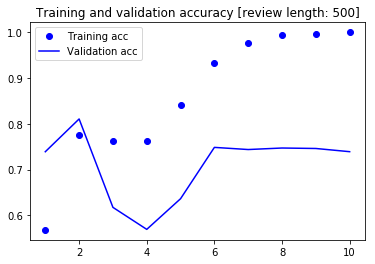

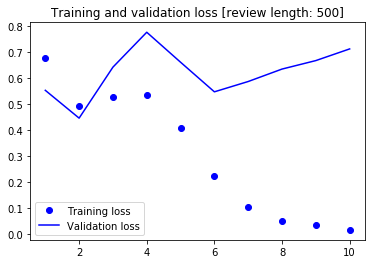

In [11]:
plot_history(history, review_length=500)

The validation accuracy tops 81%, then starting at around epoch 7, the network overfits to the training data. Well this model doesn't show any improvement, is more complex and takes longer to train. Anyway the SimpleRNN is prone to gradient vanishing / exploding so that might be one reason for the poor performance (compared to a standard NN).

## LSTM model

An improvement to the SimpleRNN is definitely the LSTM model, or a Gated Recurrent Unit GRU). These two models solve the vahishing / exploding gradient problem and are the state-of-the-art at the moment for sequence data. Let's apply the LSTM in the following.

In [16]:
def create_train_lstm_model():
    from keras.models import Sequential
    from keras.layers import Dense, Embedding, LSTM
    
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

    return model, history

In [17]:
model, history = create_train_lstm_model()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 2688/15000 [====>.........................] - ETA: 59s - loss: 0.6923 - acc: 0.5439 

KeyboardInterrupt: 